In [1]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)

device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
%env SM_FRAMEWORK=tf.keras
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import cv2
import sys
import json
import time
import pickle
import shutil
import numba
import numpy as np
import pandas as pd 
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
from tqdm import tqdm
print('tensorflow version:', tf.__version__)

pd.set_option('display.max_columns', None)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.4.1


In [3]:
TEST = True
KAGGLE = False
VER = "v69"
DATA_PATH = f"../input/hubmap-kidney-segmentation"
MDLS_PATH = f"./models_{VER}"
SUB_PATH = f"{DATA_PATH}/test" if TEST else f"{DATA_PATH}/train"
IDNT = rasterio.Affine(1, 0, 0, 0, 1, 0)
EXPAND = 4
MIN_OVERLAP = 256
STRATEGY = tf.distribute.get_strategy()
TTAS = [0]
THRESHOLD = 0.5
VOTERS = 1
TARGET_IMG = 'afa5e8098.tiff'
start_time = time.time()
Y_SHFT = -40
X_SHFT = -24

In [4]:
with open(f"{MDLS_PATH}/params.json") as file:
    PARAMS = json.load(file)
print(f"loaded params: {PARAMS}")

loaded params: {'version': 'v04', 'folds': 6, 'img_size': 256, 'resize': 4, 'batch_size': 20, 'epochs': 40, 'patience': 20, 'backbone': 'efficientnetb2', 'loss': 'bce_dice', 'mirror': False, 'umodel': 'unet', 'bce_weight': 1.0, 'shift': True, 'pseudo': '', 'lr': 0.0002, 'best_epoch': 37.0, 'best_loss': 0.005252151750028133, 'best_dice_coef': 0.9087584614753723}


In [5]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) -1 
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

def global_shift_mask(maskpred1, y_shift, x_shift):
    """
    applies a global shift to a mask by padding
    one side and cropping from the other
    """
    if y_shift < 0 and x_shift >=0:
        maskpred2 = np.pad(maskpred1, [(0,abs(y_shift)), (abs(x_shift), 0)], mode='constant', constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, :maskpred1.shape[1]]
    elif y_shift >=0 and x_shift <0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (0, abs(x_shift))], mode='constant', constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], abs(x_shift):]
    elif y_shift >=0 and x_shift >=0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (abs(x_shift), 0)], mode='constant', constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], :maskpred1.shape[1]]
    elif y_shift < 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(0, abs(y_shift)), (0, abs(x_shift))], mode='constant', constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, abs(x_shift):]
    return maskpred3
        

In [6]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * itnersection + smooth) / (K.sum(y_true_f) + K.sum(y_pref_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return params["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - params["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice",
              umodel = "unet", classes = 1, lr = 0.001):
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
        else:
            raise AttributeError("loss mode parameter error")
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = "imagenet",
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = "imagenet",
                       input_shape = input_shape,
                       classes = classes, activation = "sigmoid")
        else:
            raise AttributeError("umodel mode parameter error")
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr)
            ),
            loss = loss,
            metrics = [dice_coef]
        )
    return model            

In [7]:
def make_grid(shape, window = 256, min_overlap = 32):
    x,y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num = nx, endpoint = False, dtype= np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype = np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx, ny, 4), dtype = np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx * ny, 4)

In [8]:
img_files = [x for x in os.listdir(SUB_PATH) if ".tiff" in x]
print(f"images idxs: {img_files}")

images idxs: ['2ec3f1bb9.tiff', '3589adb90.tiff', '57512b7f1.tiff', 'aa05346ff.tiff', 'd488c759a.tiff']


In [9]:
subm = {}
for i_img, img_file in enumerate(img_files):
    print("-" * 20, img_file, "_" * 20)
    img_data = rasterio.open(os.path.join(SUB_PATH, img_file), transform=IDNT)
    print("img shape: ", img_data.shape)
    if img_data.count != 3:
        print("img file with subdatasets as channels")
        layers = [rasterio.open(subd) for subd in img_data.subdatasets]
    img_preds = np.zeros(img_data.shape, dtype=np.uint8)
    tile_size = int(PARAMS["img_size"] * EXPAND)
    tile_resized = int(tile_size * PARAMS["resize"])
    slices = make_grid(
        img_data.shape,
        window = tile_resized,
        min_overlap = MIN_OVERLAP
    )
    models = []
    folds = [0]
    for n_fold in folds:
        checkpoint_path = f"{MDLS_PATH}/model_{n_fold}.hdf5"
        model = get_model(
            PARAMS["backbone"],
            input_shape = (tile_size, tile_size, 3),
            loss_type = PARAMS["loss"],
            umodel = PARAMS["umodel"]
        )
        model.load_weights(checkpoint_path)
        models.append(model)
    for (x1, x2, y1, y2) in tqdm(slices, desc = f"{img_file}"):
        if img_data.count == 3: #normal
            img = img_data.read(
                [1,2,3],
                window = Window.from_slices((x1, x2), (y1, y2))
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((tile_resized, tile_resized, 3), dtype = np.uint8)
            for fl in range(3):
                img[:, :, fl] = layers[fl].read(
                    window = Window.from_slices((x1,x2), (y1, y2))
                )
        img = cv2.resize(img, (tile_size, tile_size))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        pred = np.zeros((tile_size, tile_size), dtype = np.float32)
        for tta_mode in TTAS:
            img_aug = img
            img_aug = np.expand_dims(img_aug, 0)
            img_aug = img_aug.astype(np.float32) / 255
            pred_aug = np.zeros((tile_size, tile_size), dtype = np.float32)
            for model in models:
                pred_aug += np.squeeze(model.predict(img_aug)) / len(models)
        pred += pred_aug / len(TTAS)
        pred = cv2.resize(pred, (tile_resized, tile_resized))
        img_preds[x1:x2, y1:y2] = img_preds[x1:x2, y1:y2] + (pred > THRESHOLD).astype(np.uint8)
    del model, models, img, pred, img_aug, pred_aug; gc.collect()
    print("img max", np.max(img_preds), "| voters:", VOTERS)
    if img_file == TARGET_IMG:
        print("global shift")
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
        img_preds = global_shift_mask(img_preds, Y_SHFT, X_SHFT)
    else:
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
    rle_pred = rle_encode_less_memory(img_preds)
    subm[i_img] = {"id": img_file.replace(".tiff", ""), "predicted": rle_pred}
    del img_preds, img_data, rle_pred; gc.collect()

elapsed_time = time.time() - start_time
print(f"time elapsed: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec")

-------------------- 2ec3f1bb9.tiff ____________________
img shape:  (23990, 47723)


2ec3f1bb9.tiff: 100%|██████████████████████████████████████████████████████████████████| 91/91 [00:33<00:00,  2.70it/s]


img max 4 | voters: 1
-------------------- 3589adb90.tiff ____________________
img shape:  (29433, 22165)


3589adb90.tiff: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.15it/s]


img max 4 | voters: 1
-------------------- 57512b7f1.tiff ____________________
img shape:  (33240, 43160)
img file with subdatasets as channels


57512b7f1.tiff: 100%|████████████████████████████████████████████████████████████████| 108/108 [00:28<00:00,  3.75it/s]


img max 4 | voters: 1
-------------------- aa05346ff.tiff ____________________
img shape:  (30720, 47340)
img file with subdatasets as channels


aa05346ff.tiff: 100%|████████████████████████████████████████████████████████████████| 117/117 [00:31<00:00,  3.70it/s]


img max 4 | voters: 1
-------------------- d488c759a.tiff ____________________
img shape:  (46660, 29020)
img file with subdatasets as channels


d488c759a.tiff: 100%|████████████████████████████████████████████████████████████████| 104/104 [00:28<00:00,  3.66it/s]


img max 4 | voters: 1
time elapsed: 2 min 60 sec


In [10]:
df_sub = pd.DataFrame(subm).T
df_sub

,id,predicted
0,2ec3f1bb9,61242046 7 61242132 3 61266033 14 61266062 13 ...
1,3589adb90,68776717 30 68806130 54 68835556 64 68864984 7...
2,57512b7f1,329085523 25 329118757 38 329151993 46 3291852...
3,aa05346ff,53317515 13 53348212 48 53378910 78 53409625 8...
4,d488c759a,338544396 64 338591056 64 338637717 62 3386843...


In [11]:
df_sub.to_csv("submission.csv", index = False)

(23990, 47723, 3)
(23990, 47723)


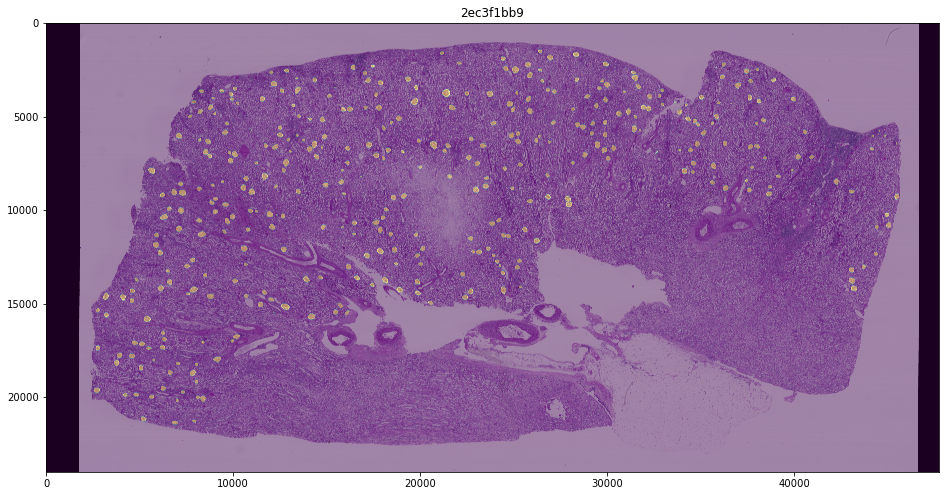

time elapsed: 4 min, 12 sec


In [12]:
if not TEST:
    df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
    idx = df_sub.iloc[0].id
    img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
    if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1,2,0))
    msk_p = enc2mask([df_sub.iloc[0].predicted], (img.shape[1], img.shape[0]))
    msk = enc2mask([df_masks.loc[idx, "encoding"]], (img.shape[1], img.shape[0]))
    print(img.shape)
    print(msk_p.shape)
    print(msk.shape)
    plt.figure(figsize = (16, 16))
    plt.imshow(img)
    plt.imshow(msk_p, alpha = 0.6)
    plt.imshow(msk, alpha = 0.3)
    plt.title(idx)
    plt.show()
else:
    idx = df_sub.iloc[0].id
    img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
    if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1,2,0))
    msk_p = enc2mask([df_sub.iloc[0].predicted], (img.shape[1], img.shape[0]))
    print(img.shape)
    print(msk_p.shape)
    plt.figure(figsize = (16, 16))
    plt.imshow(img)
    plt.imshow(msk_p, alpha = 0.4)
    plt.title(idx)
    plt.show()
elapsed_time = time.time() - start_time
print(f"time elapsed: {elapsed_time // 60:.0f} min, {elapsed_time % 60:.0f} sec")

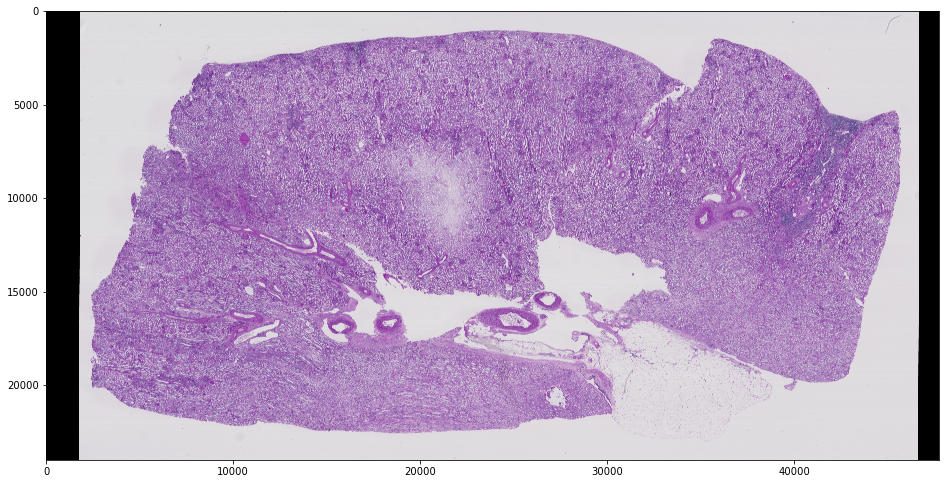

In [13]:
plt.figure(figsize = (16,16))
plt.imshow(img)
plt.show()
